### examples obtained from https://katbailey.github.io/post/gaussian-processes-for-dummies/ 
            http://krasserm.github.io/2018/03/19/gaussian-processes/

In [10]:
import numpy as np
import matplotlib.pyplot as pl

# Test data
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

In [6]:
Xtest.shape

(50, 1)

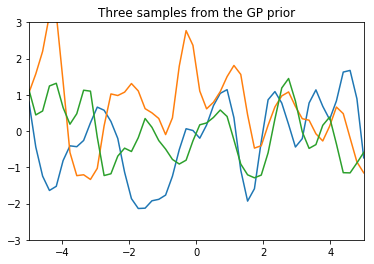

In [7]:
# Define the kernel function
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

param = 0.1
K_ss = kernel(Xtest, Xtest, param)


# Get cholesky decomposition (square root) of the
# covariance matrix
L = np.linalg.cholesky(K_ss + 1e-15*np.eye(n))
# Sample 3 sets of standard normals for our test points,
# multiply them by the square root of the covariance matrix
f_prior = np.dot(L, np.random.normal(size=(n,3)))

# Now let's plot the 3 sampled functions.
pl.plot(Xtest, f_prior)
pl.axis([-5, 5, -3, 3])
pl.title('Three samples from the GP prior')
pl.show()

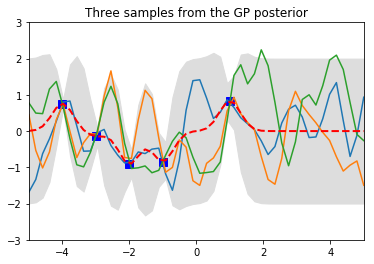

In [8]:
# Noiseless training data
Xtrain = np.array([-4, -3, -2, -1, 1]).reshape(5,1)
ytrain = np.sin(Xtrain)

# Apply the kernel function to our training points
K = kernel(Xtrain, Xtrain, param)
L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

# Compute the mean at our test points.
K_s = kernel(Xtrain, Xtest, param)
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)
# Draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))

pl.plot(Xtrain, ytrain, 'bs', ms=8)
pl.plot(Xtest, f_post)
pl.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
pl.plot(Xtest, mu, 'r--', lw=2)
pl.axis([-5, 5, -3, 3])
pl.title('Three samples from the GP posterior')
pl.show()

In [9]:
L

array([[ 9.99977800e-01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.11741076e-01,  5.82498103e-01,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.33589409e-01,  7.77232553e-01,  4.21657662e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-4.10510294e-46, -3.83107537e-45, -1.75238241e-44, ...,
         2.76087517e-01,  0.00000000e+00,  0.00000000e+00],
       [-2.18466060e-49, -2.03882815e-48, -9.32585825e-48, ...,
         6.57799570e-01,  2.76091439e-01,  0.00000000e+00],
       [-7.66590146e-53, -7.15418024e-52, -3.27241268e-51, ...,
         6.22900487e-01,  6.57802566e-01,  2.76094008e-01]])

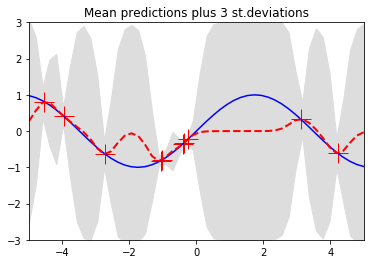

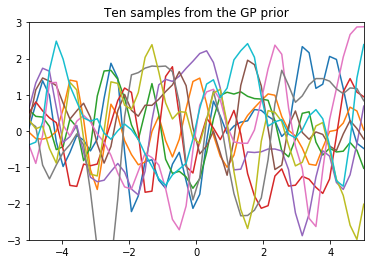

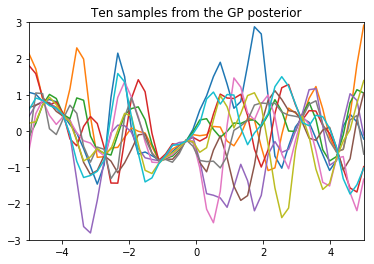

In [10]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as pl

""" This is code for simple GP regression. It assumes a zero mean GP Prior """


# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()
#f = lambda x: (0.25*(x**2)).flatten()


# Define the kernel
def kernel(a, b):
    """ GP squared exponential kernel """
    kernelParameter = 0.1
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/kernelParameter) * sqdist)

N = 10         # number of training points.
n = 50         # number of test points.
s = 0.00005    # noise variance.

# Sample some input points and noisy versions of the function evaluated at
# these points. 
X = np.random.uniform(-5, 5, size=(N,1))
y = f(X) + s*np.random.randn(N)

K = kernel(X, X)
L = np.linalg.cholesky(K + s*np.eye(N))

# points we're going to make predictions at.
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest))
mu = np.dot(Lk.T, np.linalg.solve(L, y))

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest)
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
s = np.sqrt(s2)


# PLOTS:
pl.figure(1)
pl.clf()
pl.plot(X, y, 'r+', ms=20)
pl.plot(Xtest, f(Xtest), 'b-')
pl.gca().fill_between(Xtest.flat, mu-3*s, mu+3*s, color="#dddddd")
pl.plot(Xtest, mu, 'r--', lw=2)
pl.savefig('predictive.png', bbox_inches='tight')
pl.title('Mean predictions plus 3 st.deviations')
pl.axis([-5, 5, -3, 3])

# draw samples from the prior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n))
f_prior = np.dot(L, np.random.normal(size=(n,10)))
pl.figure(2)
pl.clf()
pl.plot(Xtest, f_prior)
pl.title('Ten samples from the GP prior')
pl.axis([-5, 5, -3, 3])
pl.savefig('prior.png', bbox_inches='tight')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,10)))
pl.figure(3)
pl.clf()
pl.plot(Xtest, f_post)
pl.title('Ten samples from the GP posterior')
pl.axis([-5, 5, -3, 3])
pl.savefig('post.png', bbox_inches='tight')

pl.show()

In [11]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [12]:
np.random.seed(1)

def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

In [13]:
X

array([[1.],
       [3.],
       [5.],
       [6.],
       [7.],
       [8.]])

In [14]:
y

array([ 0.84147098,  0.42336002, -4.79462137, -1.67649299,  4.59890619,
        7.91486597])

In [18]:
y.shape

(20,)

In [19]:
X.shape

(20, 1)

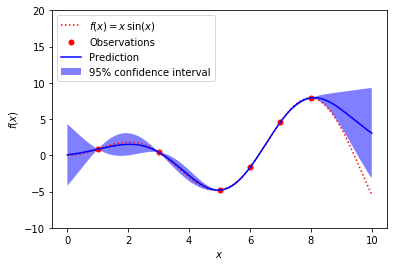

In [15]:
# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

In [16]:
x.shape

(1000, 1)

#### now the noisy case

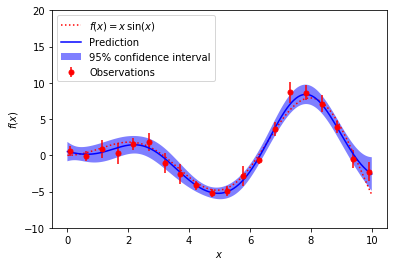

In [17]:

X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

plt.show()

### sckit learn cook book

In [1]:
from sklearn.datasets import load_boston

In [2]:
 boston = load_boston()

In [4]:
boston_X = boston.data
boston_y = boston.target

In [5]:
boston_X.shape

(506, 13)

In [8]:
boston_X[0:2,:]

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, 0.0000e+00, 5.3800e-01,
        6.5750e+00, 6.5200e+01, 4.0900e+00, 1.0000e+00, 2.9600e+02,
        1.5300e+01, 3.9690e+02, 4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
        6.4210e+00, 7.8900e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
        1.7800e+01, 3.9690e+02, 9.1400e+00]])

In [11]:
train_set = np.random.choice([True, False], len(boston_y),p=[.75, .25])

In [13]:
train_set[0:2]

array([ True,  True])

In [17]:
sample = boston_X[train_set]
sample.shape

(385, 13)

In [15]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [18]:
gp = GaussianProcessRegressor()
gp.fit(boston_X[train_set], boston_y[train_set])

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [19]:
test_preds = gp.predict(boston_X[~train_set])

Text(0.5, 1.0, 'Histogram of Residuals')

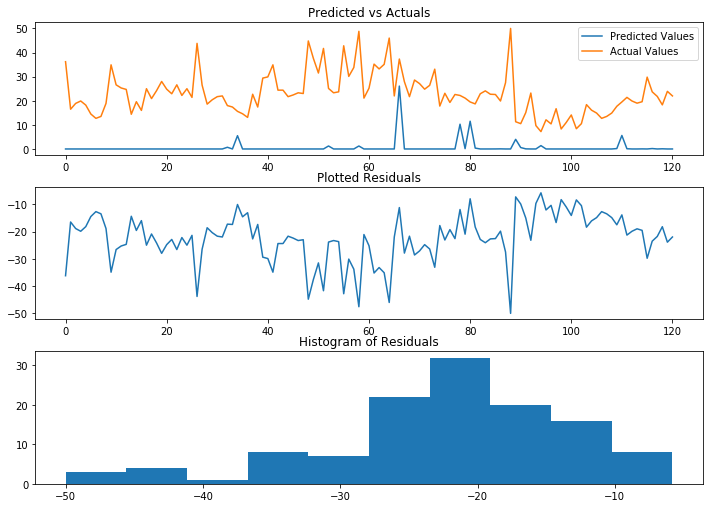

In [21]:
from matplotlib import pyplot as plt
f, ax = plt.subplots(figsize=(10, 7), nrows=3)
f.tight_layout()

ax[0].plot(range(len(test_preds)), test_preds,label='Predicted Values');
ax[0].plot(range(len(test_preds)), boston_y[~train_set],label='Actual Values');
ax[0].set_title("Predicted vs Actuals")
ax[0].legend(loc='best')
ax[1].plot(range(len(test_preds)),test_preds - boston_y[~train_set]);
ax[1].set_title("Plotted Residuals")
ax[2].hist(test_preds - boston_y[~train_set]);
ax[2].set_title("Histogram of Residuals")